In [1]:
from nilearn import datasets, plotting, image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

/home/ogrisel/.virtualenvs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# By default 2nd subject will be fetched
data = datasets.fetch_haxby(subjects=(2,))
# 'func' is a list of filenames: one for each subject
fmri_filename = data.func[0]

# print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %
      fmri_filename)  # 4D data

First subject functional nifti images (4D) are at: /home/ogrisel/nilearn_data/haxby2001/subj2/bold.nii.gz


/home/ogrisel/.virtualenvs/py36/lib/python3.6/site-packages/nilearn/image/image.py:192: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Converting to None (no smoothing option)
  .format(fwhm))


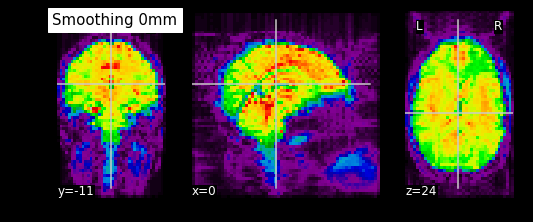

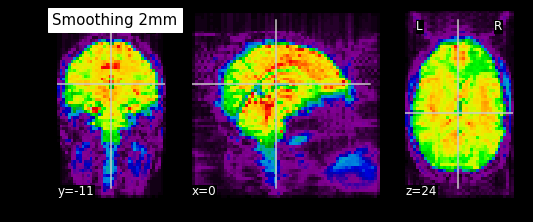

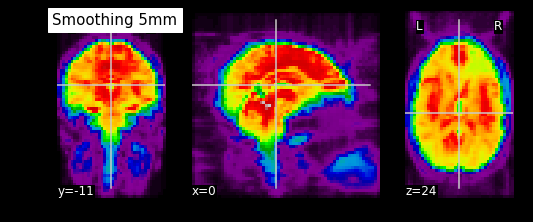

In [3]:
first_epi_file = data.func[0]

# First the compute the mean image, from the 4D series of image
mean_func = image.mean_img(first_epi_file)

# Then we smooth, with a varying amount of smoothing, from none to 20mm
# by increments of 5mm
for smoothing in [0, 2, 5] :
    smoothed_img = image.smooth_img(mean_func, smoothing)
    plotting.plot_epi(smoothed_img, title="Smoothing %imm" % smoothing)

In [4]:
smoothed_img = image.smooth_img(fmri_filename, 2)

In [5]:
smoothed_img.shape

(40, 64, 64, 1452)

In [6]:
smoothed_img.shape

(40, 64, 64, 1452)

In [7]:
smoothed_data = smoothed_img.get_data().transpose(3, 0, 1, 2)
smoothed_data = smoothed_data[:, :, :, :, None]
scale = smoothed_data.std()
smoothed_data = smoothed_data / scale
smoothed_data.shape

(1452, 40, 64, 64, 1)

In [8]:
smoothed_data_train = smoothed_data[:1200]
smoothed_data_test = smoothed_data[1200:]

In [9]:
smoothed_data_train.nbytes / 1e6

786.432

In [10]:
input_shape = smoothed_data_train.shape[1:]

In [11]:
from keras.models import load_model


autoencoder = load_model('haxby_autoencoder_best.hdf5')

Using TensorFlow backend.


In [12]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 128)               1447360   
_________________________________________________________________
sequential_3 (Sequential)    (None, 40, 64, 64, 1)     1898129   
Total params: 3,345,489
Trainable params: 3,343,345
Non-trainable params: 2,144
_________________________________________________________________
None


In [13]:
encoder = autoencoder.layers[0]
decoder = autoencoder.layers[1]

In [14]:
print(encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 40, 64, 64, 16)    448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 64, 64, 16)    64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 20, 32, 32, 32)    13856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 32, 32, 32)    128       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 20, 32, 32, 32)    27680     
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 32, 32, 32)    128       
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 16, 16, 64)    55360     
__________

In [17]:
%%time
encoded_train = encoder.predict(smoothed_data_train,
                                batch_size=32)

CPU times: user 1.98 s, sys: 196 ms, total: 2.17 s
Wall time: 5.22 s


In [18]:
encoded_train.shape

(1200, 128)

In [19]:
encoded_train.nbytes / 1e6

0.6144

In [20]:
print(decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 2, 128)      0         
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 4, 4, 4, 128)      442496    
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 4, 4, 128)      512       
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 4, 4, 4, 128)      442496    
_________________________________________________________________
batch_normalization_9 (Batch (None, 4, 4, 4, 128)      512       
__________

In [21]:
%%time
reconstructed_train = autoencoder.predict(smoothed_data_train)
reconstructed_test = autoencoder.predict(smoothed_data_test)

CPU times: user 8.81 s, sys: 2.36 s, total: 11.2 s
Wall time: 14.7 s


In [22]:
reconstructed_test.shape

(252, 40, 64, 64, 1)

In [23]:
reconstructed_test.nbytes / 1e6 

165.15072

In [24]:
from nibabel import Nifti1Image

reconstructed_test_img = Nifti1Image(reconstructed_test[:, :, :, :, 0].transpose(1, 2, 3, 0)[:, :, :, 130],
                                     smoothed_img.affine)
reconstructed_test_img.shape

(40, 64, 64)

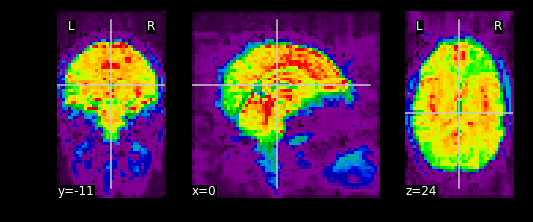

In [25]:
mean_reconstructed_test_img = image.mean_img(reconstructed_test_img)
plotting.plot_epi(mean_reconstructed_test_img)

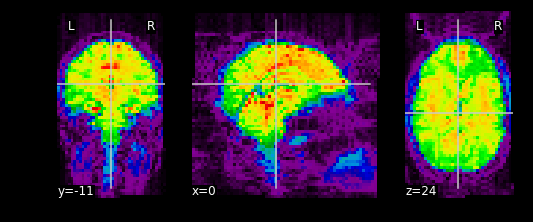

In [26]:
original_test_img = Nifti1Image(smoothed_data_test[:, :, :, :, 0].transpose(1, 2, 3, 0)[:, :, :, 130],
                                smoothed_img.affine)
mean_original_test_img = image.mean_img(original_test_img)
plotting.plot_epi(mean_original_test_img)